A notebook to visualize the av2 dataset along with its annotations

In [1]:
import os
from av2.datasets.sensor.av2_sensor_dataloader import  AV2SensorDataLoader
from pathlib import Path

home = os.path.expanduser("~")

dataset_path = os.path.join(home,"buni","dataset", "av2", "train")

os.listdir(dataset_path)

dataset = AV2SensorDataLoader(Path(dataset_path), Path(dataset_path))
scene_idx = 0
frame_idx = 50
print(dataset.get_log_ids()[scene_idx])
log_id = dataset.get_log_ids()[scene_idx]
# print(dataset.get_ordered_log_lidar_timestamps(log_id)[frame_idx])
# timestamp = dataset.get_ordered_log_lidar_timestamps(log_id)[frame_idx]
# timestamp = dataset.get_closest_lidar_fpath(log_id, 315968336160056000)
timestamp = 315968336160056000

ff52c01e-3d7b-32b1-b6a1-bcff3459ccdd


In [2]:
labels = dataset.get_labels_at_lidar_timestamp(log_id, timestamp)
cuboids = labels.vertices_m

In [3]:
import numpy as np
row = cuboids[0,:]

row_rounded = np.round(row, decimals=3)
row_rounded_2d = np.round(row[:,:2], decimals=3)

vertex_0 = cuboids[0,0,:2]
vertex_1 = cuboids[0,1,:2]
vertex_4 = cuboids[0,4,:2]
vertex_5 = cuboids[0,5,:2]
vertex_0.shape


(2,)

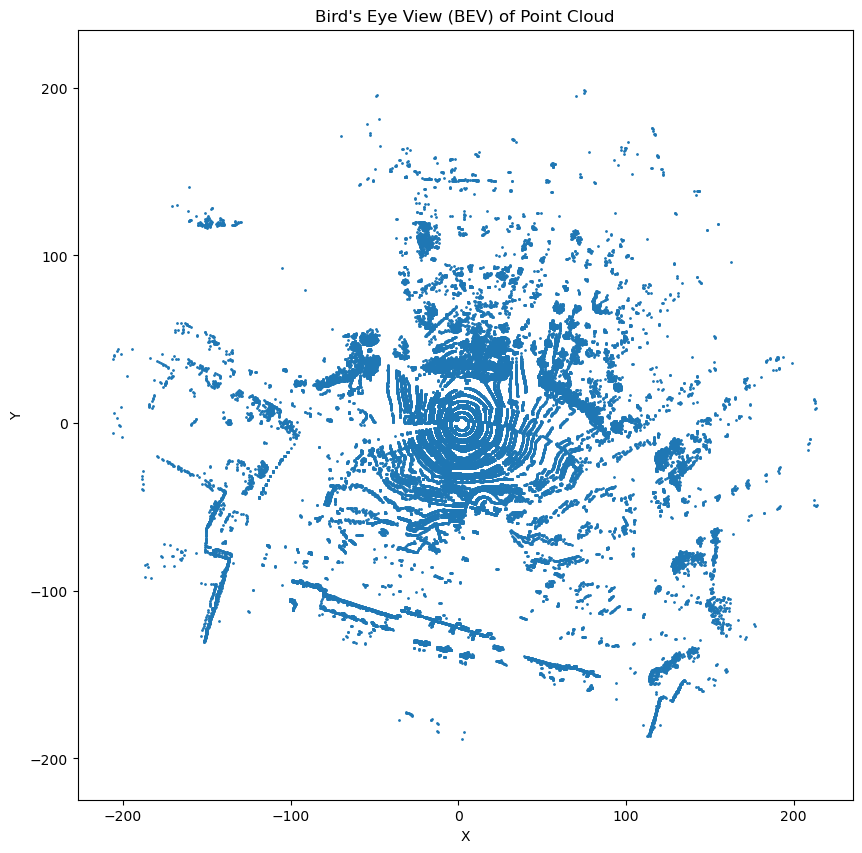

In [4]:
from av2.structures.sweep import Sweep
import matplotlib.pyplot as plt
import numpy as np
sweep = Sweep.from_feather(dataset.get_lidar_fpath_at_lidar_timestamp(log_id, timestamp))
points = sweep.xyz
def viz_points2d(points: np.ndarray):
    # Assuming points is an nx3 numpy array
    x = points[:, 0]
    y = points[:, 1]
    plt.figure(figsize=(10, 10))
    plt.scatter(x, y, s=1)  # s is the marker size
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('Bird\'s Eye View (BEV) of Point Cloud')
    plt.axis('equal')
    plt.show()
    
viz_points2d(points)

In [5]:
import open3d as o3d

def viz_pd(points):
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(points)

    # add coordinat axes to the point cloud
    mesh_frame = o3d.geometry.TriangleMesh.create_coordinate_frame(size=10, origin=[0, 0, 0])
    o3d.visualization.draw_geometries([pcd, mesh_frame])

# viz_pd(points)

In [6]:
import open3d as o3d
import numpy as np

def visualize_pointcloud_with_cuboids(points, cuboids):
    """
    Visualize a point cloud with cuboids.
    
    Args:
        points (numpy.ndarray): Nx3 array representing the point cloud.
        cuboids (list of numpy.ndarray): Each element is an 8x3 array representing 
                                         the corners of a cuboid.
    """
    # Create Open3D point cloud object
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(points)
    
    # Create coordinate frame for reference
    mesh_frame = o3d.geometry.TriangleMesh.create_coordinate_frame(size=10, origin=[0, 0, 0])
    
    # Generate Open3D LineSets for cuboids
    cuboid_geometries = []
    for cuboid in cuboids:
        # Line connections for cuboid wireframe
        lines = [
            [0, 1], [1, 2], [2, 3], [3, 0],  # Bottom face
            [4, 5], [5, 6], [6, 7], [7, 4],  # Top face
            [0, 4], [1, 5], [2, 6], [3, 7]   # Vertical edges
        ]
        
        # Create LineSet for this cuboid
        line_set = o3d.geometry.LineSet()
        line_set.points = o3d.utility.Vector3dVector(cuboid)
        line_set.lines = o3d.utility.Vector2iVector(lines)
        line_set.colors = o3d.utility.Vector3dVector([[1, 0, 0] for _ in lines])  # Red color
        
        cuboid_geometries.append(line_set)
    
    # Visualize point cloud and cuboids
    o3d.visualization.draw_geometries([pcd, mesh_frame] + cuboid_geometries)

# Example usage
# `points` is the Nx3 point cloud array
# `cuboids` is a list of 8x3 arrays representing cuboid corners
# visualize_pointcloud_with_cuboids(points, cuboids)


In [7]:
def extract_face_corners(cuboids: np.ndarray, bottom_face=True):
    """
    Extract corner coordinates of top or bottom face from cuboids.
    
    Args:
        cuboids: numpy array of shape (N, 8, 3) containing cuboid corner coordinates
        bottom_face: bool, if True return bottom face corners, else top face corners
    
    Returns:
        numpy array of shape (N, 4, 2) containing x,y coordinates of face corners
        
              5------4
            |\\    |\\
            | \\   | \\
            6--\\--7  \\
            \\  \\  \\ \\
        l    \\  1-------0    h
         e    \\ ||   \\ ||   e
          n    \\||    \\||   i
           g    \\2------3    g
            t      width.     h
             h.               t
    """
    # Select indices for bottom or top face
    face_index = [0, 1, 5, 4] if bottom_face else [3, 2, 6, 7]
    
    # Extract corners for selected face (x,y coordinates only)
    face_corners = cuboids[:, face_index, :2]
    
    return face_corners

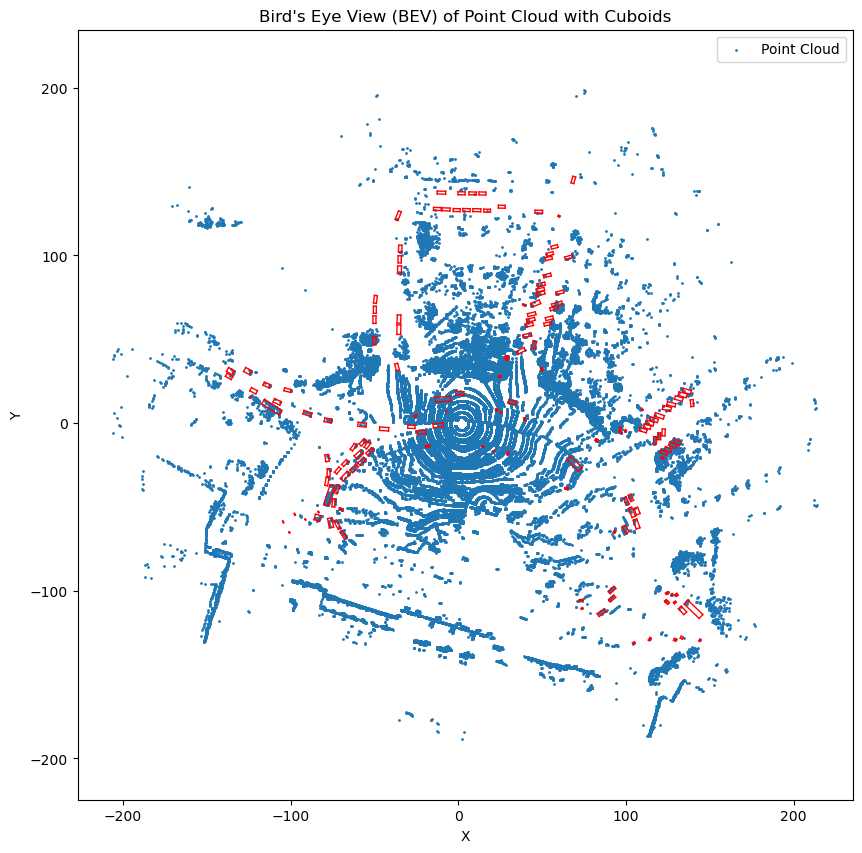

In [8]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_bev_with_cuboids(points: np.ndarray, cuboids: np.ndarray, fig_size = (10,10), bottom_face_flag= True):
    """
    Visualize a 2D BEV (Bird's Eye View) of the point cloud with cuboid annotations.

    Args:
        points (numpy.ndarray): Nx3 array representing the point cloud.
        cuboids (numpy.ndarray): Array of shape (N, 8, 3), where N is the number of cuboids,
                                 8 represents the 8 corners, and 3 represents (X, Y, Z) coordinates.
    """
    # Extract the X and Y coordinates from the point cloud
    x = points[:, 0]
    y = points[:, 1]

    # Plot the BEV of the point cloud
    plt.figure(figsize=fig_size)
    plt.scatter(x, y, s=1, label="Point Cloud")  # s=1 for small point size
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title("Bird's Eye View (BEV) of Point Cloud with Cuboids")
    plt.axis('equal')

    cuboids = extract_face_corners(cuboids, bottom_face=bottom_face_flag)
    # Process and visualize each cuboid
    for cuboid in cuboids:
        # face_index = []
        # if bottom_face_flag:
        #     face_index = [0, 1, 5, 4]
        # else: 
        #     face_index = [3, 2, 6, 7]
        # projected_corners = cuboid[face_index, :2]  # Take only the X-Y coordinates
        projected_corners = cuboid

        # Define connections for the cuboid's bottom face (BEV)
        connections = [
            [0, 1], [1, 2], [2, 3], [3, 0]  # Connections between corners of the bottom face
        ]

        # Draw lines for the cuboid in the BEV
        for start, end in connections:
            plt.plot(
                [projected_corners[start, 0], projected_corners[end, 0]],
                [projected_corners[start, 1], projected_corners[end, 1]],
                color='red', linewidth=1
            )
    
    plt.legend()
    plt.show()

# Example Usage:
# Assuming `points` is an Nx3 numpy array representing the point cloud
# Assuming `cuboids` is an (N, 8, 3) numpy array of cuboid corner coordinates
visualize_bev_with_cuboids(points, cuboids, fig_size=(10,10), bottom_face_flag=False)


In [9]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_bev_with_cuboids_ROI(points: np.ndarray, cuboids: np.ndarray, fig_size=(10, 10), bottom_face_flag=True):
    """
    Visualize a 2D BEV (Bird's Eye View) of the point cloud with cuboid annotations.

    Args:
        points (numpy.ndarray): Nx3 array representing the point cloud.
        cuboids (numpy.ndarray): Array of shape (N, 8, 3), where N is the number of cuboids,
                                 8 represents the 8 corners, and 3 represents (X, Y, Z) coordinates.
    """
    # Extract the X and Y coordinates from the point cloud
    x = points[:, 0]
    y = points[:, 1]

    # Plot the BEV of the point cloud
    plt.figure(figsize=fig_size)
    plt.scatter(x, y, s=1, label="Point Cloud")  # s=1 for small point size
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title("Bird's Eye View (BEV) of Point Cloud with Cuboids")
    plt.axis('equal')

    cuboids = extract_face_corners(cuboids, bottom_face=bottom_face_flag)
    # Process and visualize each cuboid
    for cuboid in cuboids:
        projected_corners = cuboid
        # Define connections for the cuboid's bottom face (BEV)
        connections = [
            [0, 1], [1, 2], [2, 3], [3, 0]  # Connections between corners of the bottom face
        ]

        # Draw lines for the cuboid in the BEV
        for start, end in connections:
            plt.plot(
                [projected_corners[start, 0], projected_corners[end, 0]],
                [projected_corners[start, 1], projected_corners[end, 1]],
                color='red', linewidth=1
            )
    
    plt.legend()
    plt.show()

def filter_points_and_cuboids(points, corners):
    # Define the ROI range
    x_min, x_max = 0, 70
    y_min, y_max = -40, 40

    # Filter points based on the ROI
    roi_mask = (points[:, 0] >= x_min) & (points[:, 0] <= x_max) & (points[:, 1] >= y_min) & (points[:, 1] <= y_max)
    filtered_points = points[roi_mask]

    # Filter cuboids based on the ROI
    filtered_cuboids = []
    for cuboid in corners:
        if np.any((cuboid[:, 0] >= x_min) & (cuboid[:, 0] <= x_max) & (cuboid[:, 1] >= y_min) & (cuboid[:, 1] <= y_max)):
            filtered_cuboids.append(cuboid)
    filtered_cuboids = np.array(filtered_cuboids)
    return filtered_points, filtered_cuboids


def filter_cuboids_by_roi(corners: np.ndarray, 
                         x_range: tuple = (0, 70), 
                         y_range: tuple = (-40, 40)) -> np.ndarray:
    """
    Filter cuboids based on whether they fall within specified ROI.

    Args:
        corners: numpy array of shape (N, 4, 2) containing corner coordinates
        x_range: tuple of (min_x, max_x) defining ROI x bounds
        y_range: tuple of (min_y, max_y) defining ROI y bounds

    Returns:
        numpy array containing only cuboids that fall within ROI
    """
    x_min, x_max = x_range
    y_min, y_max = y_range

    filtered_cuboids = []
    for cuboid in corners:
        # Check if any corner falls within ROI
        if np.any((cuboid[:, 0] >= x_min) & 
                  (cuboid[:, 0] <= x_max) & 
                  (cuboid[:, 1] >= y_min) & 
                  (cuboid[:, 1] <= y_max)):
            filtered_cuboids.append(cuboid)
    
    return np.array(filtered_cuboids)

# Example usage:
# filtered_cuboids = filter_cuboids_by_roi(corners, x_range=(0,70), y_range=(-40,40))

filtered_points, _ = filter_points_and_cuboids(points, cuboids)
filtered_cuboids = filter_cuboids_by_roi(cuboids)
# Example Usage:
# Assuming `points` is an Nx3 numpy array representing the point cloud
# Assuming `corners` is an (N, 8, 3) numpy array of cuboid corner coordinates
# visualize_bev_with_cuboids_ROI(filtered_points, filtered_cuboids, fig_size=(10, 10), bottom_face_flag=True)

In [10]:
from typing import List
def get_bbox_params(corners: np.ndarray) -> List:
    """
    Extract bbox parameters from corner coordinates.
    
    Args:
        corners: numpy array of shape (4,2) containing x,y coordinates
    
    Returns:
        tuple: (cx, cy, length, width, orientation)
    """
    import numpy as np
    
    # Calculate centroid
    cx = np.mean(corners[:, 0])
    cy = np.mean(corners[:, 1])
    
    # Calculate orientation
    edge = corners[3] - corners[0]
    orientation = get_orientation(corners)
    
    # Calculate length (distance between corners 0 and 1)
    length = np.linalg.norm(corners[1] - corners[0])
    
    # Calculate width (distance between corners 0 and 3)
    width = np.linalg.norm(corners[3] - corners[0])
    
    return [cx, cy, length, width, orientation]

def get_orientation(corners: np.ndarray):
    edge = corners[3] - corners[0]
    orientation = np.arctan2(edge[1], edge[0])
    if orientation < 0:
        orientation += np.pi
    return orientation

In [11]:
gt_labels_corners = extract_face_corners(filtered_cuboids, bottom_face=True) # numpy array of shape (N, 4, 2)

In [ ]:
gt_labels_corners

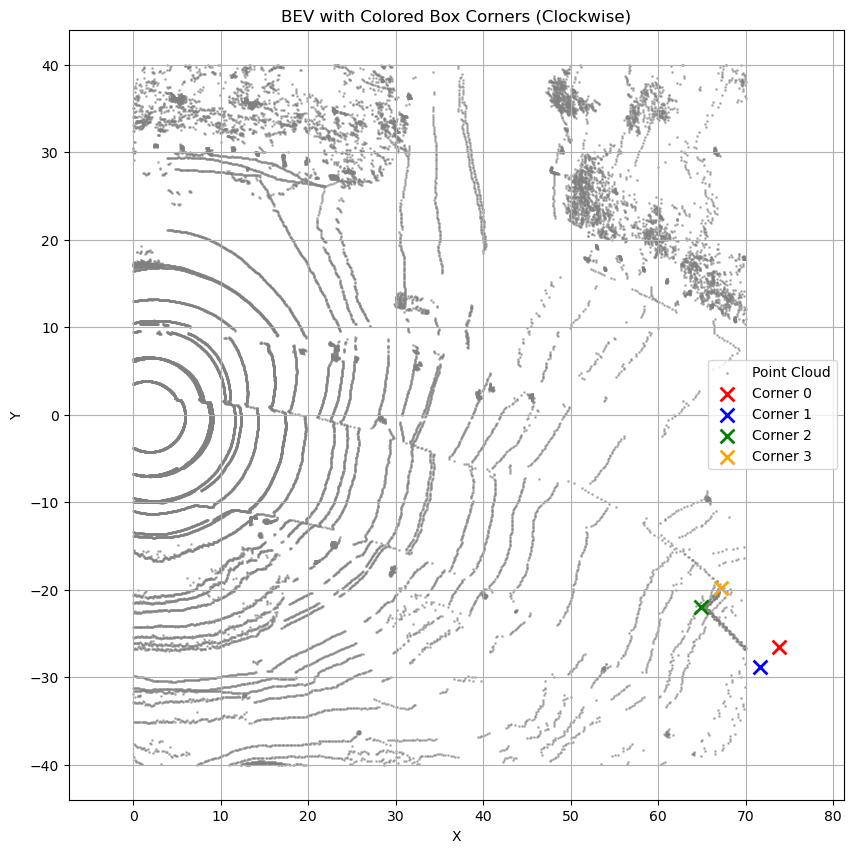

In [12]:
def visualize_corners_colored(points, bbox_corners, fig_size=(10,10)):
    """
    Visualize bbox corners with different colors overlaid on point cloud.
    
    Args:
        points: numpy array of shape (N,2) containing point cloud x,y coordinates
        bbox_corners: numpy array of shape (4,2) containing corner coordinates
        fig_size: tuple, figure size
    """
    import matplotlib.pyplot as plt
    import numpy as np
    
    # Define colors for each corner
    colors = ['red', 'blue', 'green', 'orange']
    corner_names = ['Corner 0', 'Corner 1', 'Corner 2', 'Corner 3']
    
    plt.figure(figsize=fig_size)
    
    # Plot point cloud
    plt.scatter(points[:, 0], points[:, 1], s=1, c='gray', alpha=0.5, label='Point Cloud')
    
    # Plot each corner with different color
    for i in range(4):
        plt.scatter(bbox_corners[i, 0], bbox_corners[i, 1], 
                   c=colors[i], s=100, marker='x', 
                   label=corner_names[i], linewidth=2)
    
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title("BEV with Colored Box Corners (Clockwise)")
    # plt.title(title)
    plt.axis('equal')
    plt.grid(True)
    plt.legend()
    plt.show()
test_idx= 0  # 0, 1, 18, 19, 20, 21    
visualize_corners_colored(filtered_points, gt_labels_corners[test_idx], fig_size=(10,10))

In [13]:
from typing import List, Tuple
def get_corners_debug(bbox: List[float]) -> Tuple[np.ndarray, np.ndarray]:
    """
    return the 4 corners of the bounding box in the bird's eye view
    
    Args:
        bbox:  list of the bounding box parameters of shape (5)
    
    Returns:
        bev_corners: [4 * 2] numpy array of the 4 corners' (x, y)
        reg_target: [6] numpy array of the regression targets  
    """
    x, y, l, w, yaw = bbox
    
    # w, h, l, y, z, x, yaw = bbox[8:15]
    # manually take a negative s. t. it's a right-hand system, with
    # x facing in the front windshield of the car
    # z facing up
    # y facing to the left of driver

    # yaw = -(yaw + np.pi / 2)
    
    
    bev_corners = np.zeros((4, 2), dtype=np.float32)
    # rear left
    bev_corners[0, 0] = x - l/2 * np.cos(yaw) - w/2 * np.sin(yaw)
    bev_corners[0, 1] = y - l/2 * np.sin(yaw) + w/2 * np.cos(yaw)

    # rear right
    bev_corners[1, 0] = x - l/2 * np.cos(yaw) + w/2 * np.sin(yaw)
    bev_corners[1, 1] = y - l/2 * np.sin(yaw) - w/2 * np.cos(yaw)

    # front right
    bev_corners[2, 0] = x + l/2 * np.cos(yaw) + w/2 * np.sin(yaw)
    bev_corners[2, 1] = y + l/2 * np.sin(yaw) - w/2 * np.cos(yaw)

    # front left
    bev_corners[3, 0] = x + l/2 * np.cos(yaw) - w/2 * np.sin(yaw)
    bev_corners[3, 1] = y + l/2 * np.sin(yaw) + w/2 * np.cos(yaw)

    reg_target = [np.cos(yaw), np.sin(yaw), x, y, w, l]

    return bev_corners, reg_target

def get_bbox_corners(bbox_params: list) -> list:
    """
    Calculate the four corners of each bounding box from parameters.

    Args:
        bbox_params: List of tuples, each containing (cx, cy, length, width, angle)
                    where cx,cy is center, length/width are dimensions, angle in radians

    Returns:
        corners: List of arrays, each containing four (x,y) corner coordinates
    """
    corners = []
    
    for params in bbox_params:
        cx, cy, length, width, ry = params
        
        # Half-dimensions
        half_length = length / 2
        half_width = width / 2
        
        # Rotation matrix
        rotation_matrix = np.array([
            [np.cos(ry), -np.sin(ry)],
            [np.sin(ry),  np.cos(ry)]
        ])
        
        # Local frame corners
        local_corners = np.array([
            [ half_length,  half_width],
            [ half_length, -half_width],
            [-half_length, -half_width],
            [-half_length,  half_width]
        ])
        
        # Transform to global frame
        global_corners = (rotation_matrix @ local_corners.T).T + np.array([cx, cy])
        corners.append(global_corners)
    
    return corners


In [14]:
gt_params = []
for corners in gt_labels_corners:
    bbox_params = get_bbox_params(corners)
    print(f"{bbox_params} | Orientation: {np.rad2deg(bbox_params[4])}")
    # bbox_params = np.array(bbox_params)
    gt_params.append(bbox_params)

[69.39535783988185, -24.315725421459774, 3.0923745632171653, 9.499999999999996, 2.351379533272524] | Orientation: 134.72412328995696
[49.4948061228115, 32.702260919780656, 0.744927644729608, 0.6320877671241801, 2.8528012806839245] | Orientation: 163.453473172705
[22.52324727055975, 8.064615340284945, 0.5999999999999973, 0.6000000000000006, 1.3384788116641515] | Orientation: 76.68918687604166
[65.26726719022236, -39.172804133133695, 0.7180481553077732, 0.7842186093330328, 1.1515617919534358] | Orientation: 65.97963052745403
[28.468144667031083, 39.729534623237896, 0.8106222748756428, 0.6000000000000031, 1.4441956857932392] | Orientation: 82.74631758695415
[63.932063975379606, -38.914271473335816, 0.637097179889682, 0.8886454105377142, 1.3314525954913337] | Orientation: 76.28661434339264
[23.264309438571217, 7.599040102105846, 0.6000000000000001, 0.6877679824829092, 1.3269829726618574] | Orientation: 76.03052381924833
[14.732689558542916, -13.877308699464265, 0.6374402046203619, 0.861659

In [17]:
print(gt_labels_corners[0])

[[ 73.83647501 -26.60257333]
 [ 71.6393328  -28.77865848]
 [ 64.95424067 -22.02887751]
 [ 67.15138288 -19.85279236]]


In [18]:
pixor_corners = [] # list of numpy arrays
for label in gt_params:
    corners, _ = get_corners_debug(label)
    pixor_corners.append(corners)

av2_corners = get_bbox_corners(gt_params)

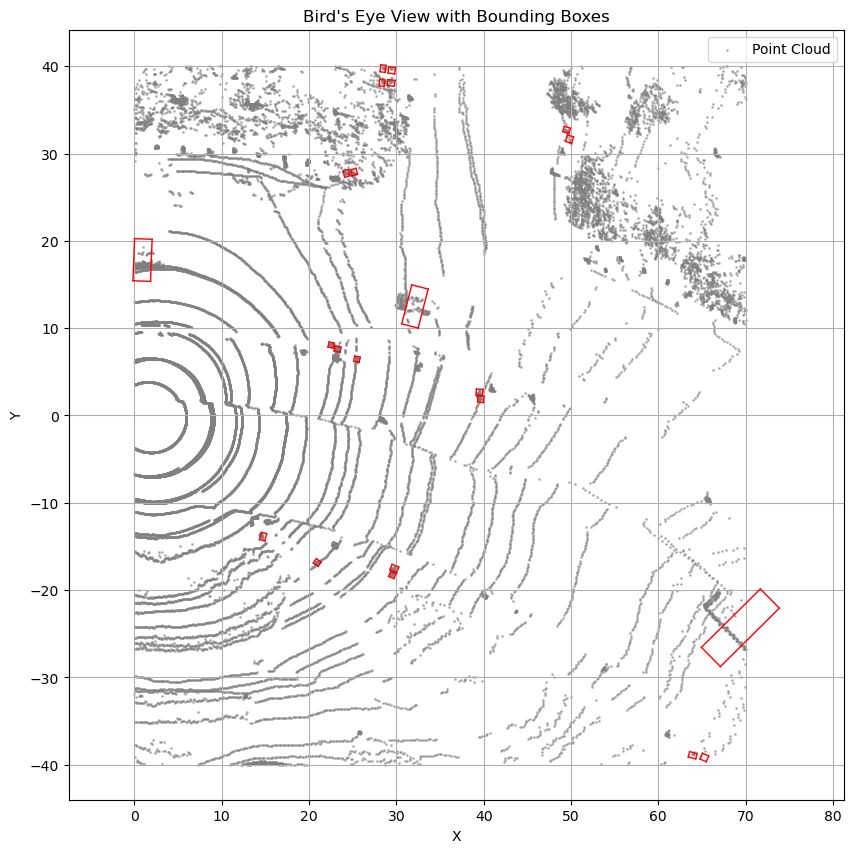

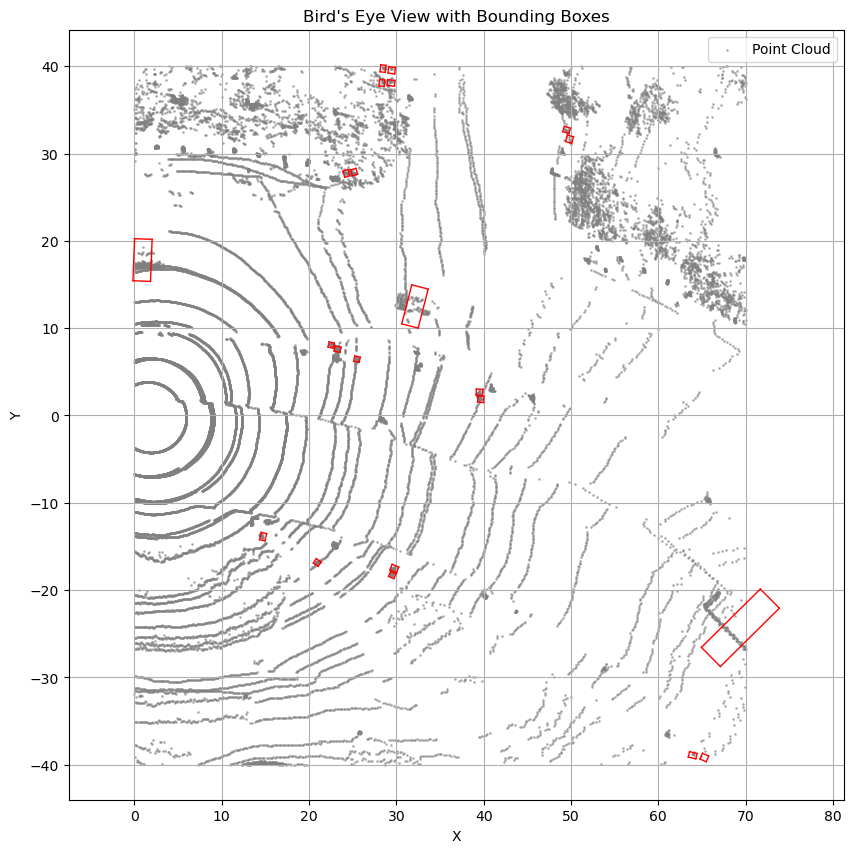

In [19]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_bboxes_on_point_cloud(points: np.ndarray, bboxes: list, fig_size=(10,10)):
    """
    Visualize multiple bounding boxes overlaid on point cloud BEV.
    
    Args:
        points: numpy array of shape (N,3) containing point cloud
        bboxes: list of numpy arrays, each of shape (4,2) containing corner coordinates
        fig_size: tuple for figure size
    """  
    plt.figure(figsize=fig_size)
    
    # Plot point cloud
    plt.scatter(points[:, 0], points[:, 1], s=1, c='gray', alpha=0.5, label='Point Cloud')
    
    # Define box connections
    connections = [[0, 1], [1, 2], [2, 3], [3, 0]]
    
    # Plot each bbox
    for bbox in bboxes:
        for start, end in connections:
            plt.plot(
                [bbox[start, 0], bbox[end, 0]], 
                [bbox[start, 1], bbox[end, 1]],
                color='red', linewidth=1
            )
    
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title("Bird's Eye View with Bounding Boxes")
    plt.axis('equal')
    plt.grid(True)
    plt.legend()
    plt.show()

# Example usage:
visualize_bboxes_on_point_cloud(filtered_points, av2_corners)
visualize_bboxes_on_point_cloud(filtered_points, pixor_corners)